## Anomaly Detection - Project
### Authors: Norbert Klockiewicz, Kacper Majchrzak, Patryk Kożuch

#### Based on: <a href="https://arxiv.org/pdf/1802.04431.pdf">Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding</a>

Imports

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import more_itertools as mit
from keras.models import Sequential, load_model
from keras.callbacks import History, EarlyStopping
from keras.layers import Dense, Activation, Dropout, LSTM

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
CHANNEL = "D-12"

### Class channel - load and prepare data to train model

In [ ]:
class Channel:
    def __init__(self, chan_id):
        self.id = chan_id
        self.train = None
        self.test = None
        self.l_s = 250
        self.n_predictions = 10
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.y_hat = None

    def shape_data(self, arr, training=True):
        data = []
        for i in range(len(arr) - self.l_s - self.n_predictions):
            data.append(arr[i: i + self.l_s + self.n_predictions])
            
        data = np.array(data)

        if training:
            np.random.shuffle(data)
            self.X_train = data[:, :-self.n_predictions, :]
            self.y_train = data[:, -self.n_predictions:, 0]
        else:
            self.X_test = data[:, :-self.n_predictions, :]
            self.y_test = data[:, -self.n_predictions:, 0]

    def load_data(self):
        try:
            self.train = np.load(os.path.join("data", "train", "{}.npy".format(self.id)))
            self.test = np.load(os.path.join("data", "test", "{}.npy".format(self.id)))
        except FileNotFoundError as e:
            print(e)

        self.shape_data(self.train)
        self.shape_data(self.test, training=False)

In [ ]:
new_channel = Channel(CHANNEL)
new_channel.load_data()

### Class Model - create and train recurrent neural network

In [ ]:
class Model:
    def __init__(self, channel):
        self.chan_id = channel.id
        self.y_hat = np.array([])
        self.model = None
        self.train_new(channel)
        

    def train_new(self, channel):
        cbs = [History(), EarlyStopping(monitor='val_loss',
                                        patience=10,
                                        min_delta=0.0003,
                                        verbose=0)]

        self.model = Sequential()

        self.model.add(LSTM(
            80,
            input_shape=(None, channel.X_train.shape[2]),
            return_sequences=True))
        self.model.add(Dropout(0.3))

        self.model.add(LSTM(
            80,
            return_sequences=False))
        self.model.add(Dropout(0.3))

        self.model.add(Dense(
            channel.n_predictions))
        self.model.add(Activation('linear'))

        self.model.compile(loss='mse',
                           optimizer='adam')

        self.model.fit(channel.X_train,
                       channel.y_train,
                       batch_size=64,
                       epochs=35,
                       validation_split=0.2,
                       callbacks=cbs,
                       verbose=True)
        
    def aggregate_predictions(self, y_hat_batch, method='first'):
        agg_y_hat_batch = np.array([])

        for t in range(len(y_hat_batch)):

            start_idx = t - 10
            start_idx = start_idx if start_idx >= 0 else 0

            # predictions pertaining to a specific timestep lie along diagonal
            y_hat_t = np.flipud(y_hat_batch[start_idx:t+1]).diagonal()

            if method == 'first':
                agg_y_hat_batch = np.append(agg_y_hat_batch, [y_hat_t[0]])
            elif method == 'mean':
                agg_y_hat_batch = np.append(agg_y_hat_batch, np.mean(y_hat_t))

        agg_y_hat_batch = agg_y_hat_batch.reshape(len(agg_y_hat_batch), 1)
        self.y_hat = np.append(self.y_hat, agg_y_hat_batch)
              
    def batch_predict(self, channel):
        num_batches = int((channel.y_test.shape[0] - 250)
                          / 70)

        for i in range(0, num_batches + 1):
            prior_idx = i * 70
            idx = (i + 1) * 70

            if i + 1 == num_batches + 1:
                idx = channel.y_test.shape[0]

            X_test_batch = channel.X_test[prior_idx:idx]
            y_hat_batch = self.model.predict(X_test_batch)
            self.aggregate_predictions(y_hat_batch)

        self.y_hat = np.reshape(self.y_hat, (self.y_hat.size,))

        channel.y_hat = self.y_hat

        return channel


In [ ]:
model = Model(new_channel)

Epoch 1/35


2024-03-16 15:29:58.790874: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 15:29:59.015242: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 15:30:00.783808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 15:30:02.538393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 15:30:16.752063: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - ETA: 0s - loss: 0.9531

2024-03-16 15:30:31.102176: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 15:30:31.177791: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 15:30:32.970087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 38s 38s/step - loss: 0.9531 - val_loss: 0.8283
Epoch 2/35
1/1 [==============================] - 0s 257ms/step - loss: 0.8330 - val_loss: 0.7093
Epoch 3/35
1/1 [==============================] - 0s 223ms/step - loss: 0.7160 - val_loss: 0.5828
Epoch 4/35
1/1 [==============================] - 0s 224ms/step - loss: 0.5929 - val_loss: 0.4423
Epoch 5/35
1/1 [==============================] - 0s 224ms/step - loss: 0.4582 - val_loss: 0.2884
Epoch 6/35
1/1 [==============================] - 0s 224ms/step - loss: 0.3136 - val_loss: 0.1411
Epoch 7/35
1/1 [==============================] - 0s 220ms/step - loss: 0.1803 - val_loss: 0.0520
Epoch 8/35
1/1 [==============================] - 0s 221ms/step - loss: 0.1086 - val_loss: 0.0612
Epoch 9/35
1/1 [==============================] - 0s 224ms/step - loss: 0.1329 - val_loss: 0.0835
Epoch 10/35
1/1 [==============================] - 0s 217ms/step - loss: 0.1605 - val_loss: 0.0637
Epoch 11/35
1/1 [==============

In [ ]:
model.batch_predict(new_channel)

2024-03-16 15:30:39.734821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 15:30:39.796605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2024-03-16 15:30:41.574104: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


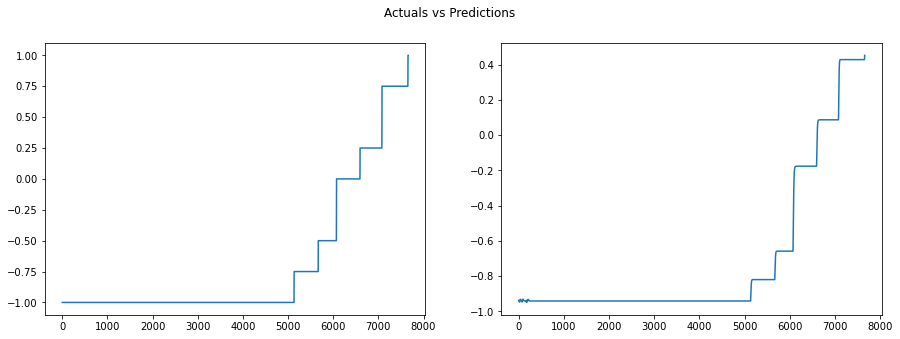

In [ ]:
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(15, 5)

fig.suptitle("Actuals vs Predictions")

ax[0].plot(new_channel.y_test[:, 0])

ax[1].plot(new_channel.y_hat)

### Class Plotter - visualize input data, predictions and errors

In [ ]:
class Plotter:
    def __init__(self, channel):
        self.channel = channel

    def plot_predictions(self, plot_real_data=True):
        if plot_real_data:
            plt.plot(self.channel.y_test[:, 0])
        else:
            plt.plot(self.channel.y_hat)

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()
        
    
    def plot_custom_range_predictions(self, start, end, plot_real_data=True):
        if plot_real_data:
            plt.plot([i for i in range(start, end)], self.channel.y_test[:, 0][start:end])
        else:
             plt.plot([i for i in range(start, end)], self.channel.y_hat[start:end])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()
        
    def plot_threshold(self, error, threshold):
        plt.figure(figsize=(20,10))
        plt.plot(error)
        plt.plot([threshold for i in range(len(error))])

        anomalies = pd.read_csv("data/labeled_anomalies.csv")
        anomalies = anomalies[anomalies["chan_id"] == self.channel.id]
        anomalies_plot = anomalies['anomaly_sequences']
        anomalies_plot = eval(anomalies_plot.iloc[0])

        for rect in anomalies_plot:
            plt.axvspan(rect[0], rect[1], alpha=0.3, color='red')
        plt.show()

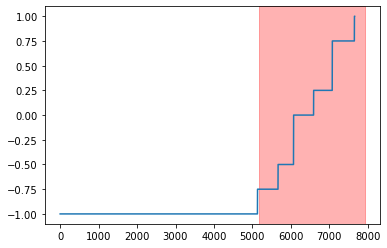

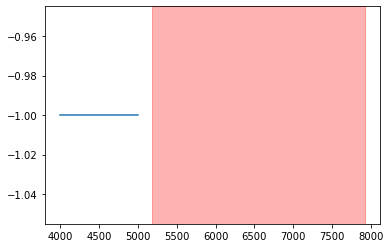

In [ ]:
plotter = Plotter(new_channel)
plotter.plot_predictions()
plotter.plot_custom_range_predictions(4000, 5000)

### Calculate error between real and predicted data, create smoothed error

In [ ]:
class ErrorWindow:
    def __init__(self, channel, e_s, window_size, window_number):
        self.channel = channel
        self.e_s = e_s
        self.window_num = window_number
        self.window_size = window_size
        self.E_seq = np.array([])
        
        self.mean = np.mean(self.e_s)
        self.std = np.std(self.e_s)
        self.epsilon = self.mean + 12 * self.std
        self.indices_anomalies = np.array([])
        # self.non_anom_max = np.max(self.e_s[self.e_s < self.epsilon])

    def calculate_epsilon(self):
        epsilon = 0
        max_score = float('-inf')

        for z in np.arange(2, 10, 0.5):
            epsilon = self.mean + (self.std * z)

            delta_mean = self.mean - np.mean(self.e_s[self.e_s < epsilon])
            delta_std = self.std - np.std(self.e_s[self.e_s < epsilon])
            e_a = self.e_s[self.e_s >= epsilon]

            if len(e_a) > 0:
                anom = np.argwhere(self.e_s >= epsilon).reshape(-1)
                E_seq =[list(g) for g in mit.consecutive_groups(anom)]
                E_seq_len = len(anom)
                
                score = ((delta_mean/self.mean) + (delta_std/self.std)) / (E_seq_len**2 + len(e_a))
                if score > max_score:
                    max_score = score
                    self.epsilon = epsilon
                    self.E_seq = E_seq
                    self.indices_anomalies = anom
                    # self.non_anom_max = np.max(self.e_s[self.e_s < self.epsilon])
        return epsilon

In [ ]:
class Errors:
    def __init__(self, channel):
        self.channel = channel
        self.error = np.abs(channel.y_test[:, 0] - channel.y_hat)
        self.normalized = np.mean(self.error / np.ptp(channel.y_test))
        self.e_s = pd.DataFrame(self.error).ewm(span=105).mean().values.flatten()

        self.window_size = 30
        self.batch_size = 70

        self.n_windows = int((channel.y_test.shape[0] - (self.batch_size * self.window_size)) / self.batch_size)
        self.epsilons = []


    def detect_anomalies(self):

        for i in range(self.n_windows + 1):
            prior_idx = i * self.batch_size
            idx = self.window_size * self.batch_size + prior_idx

            window = ErrorWindow(self.channel, self.e_s[prior_idx:idx], self.window_size, i)
            self.epsilons.append(((prior_idx, idx), window.calculate_epsilon()))

In [ ]:
errors = Errors(new_channel)
errors.detect_anomalies()
epsilons = errors.epsilons

ValueError: setting an array element with a sequence.

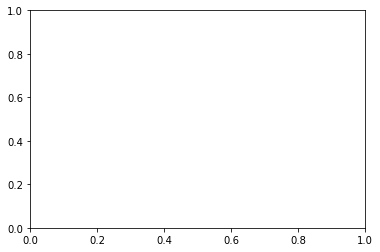

In [ ]:
plt.plot(epsilons)
plt.show()
plotter.plot_threshold(errors.e_s, np.median(epsilons))
plt.show()
plotter.plot_predictions()

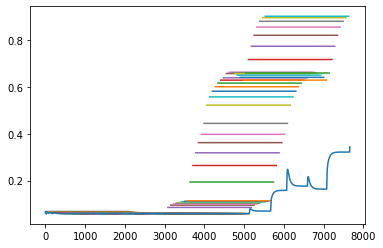

In [ ]:
for (start, end), thr in epsilons:
    plt.plot([_ for _ in range(start, end)], [thr for _ in range(start, end)])
plt.plot(errors.e_s)

In [ ]:
plotter.plot_custom_range_predictions(4650, 4800)

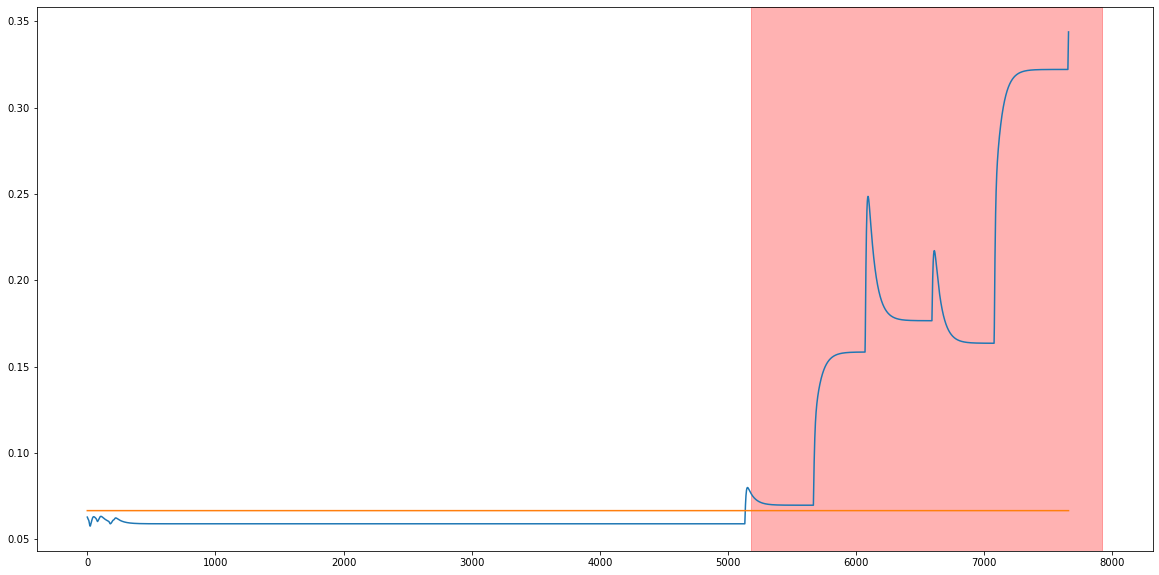

In [ ]:
plotter.plot_threshold(errors.e_s, epsilons[1][1])

In [ ]:
import numpy as np
import pandas as pd
import more_itertools as mit

class Errors:
    def __init__(self, channel):
        """
        Batch processing of errors between actual and predicted values
        for a channel.

        Args:
            channel (obj): Channel class object containing train/test data
                for X,y for a single channel
            config (obj): Config object containing parameters for processing
            run_id (str): Datetime referencing set of predictions in use

        Attributes:
            config (obj): see Args
            window_size (int): number of trailing batches to use in error
                calculation
            n_windows (int): number of windows in test values for channel
            i_anom (arr): indices of anomalies in channel test values
            E_seq (arr of tuples): array of (start, end) indices for each
                continuous anomaly sequence in test values
            anom_scores (arr): score indicating relative severity of each
                anomaly sequence in E_seq
            e (arr): errors in prediction (predicted - actual)
            e_s (arr): exponentially-smoothed errors in prediction
            normalized (arr): prediction errors as a percentage of the range
                of the channel values
                
        """
        self.window_size = 30
        self.batch_size = 70
        self.smoothing_perc = 0.05
        self.l_s = 250

        self.window_size = self.window_size
        self.n_windows = int((channel.y_test.shape[0] -
                              (self.batch_size * self.window_size))
                             / self.batch_size)
        self.i_anom = np.array([])
        self.E_seq = []
        self.anom_scores = []

        # raw prediction error
        self.e = [abs(y_h-y_t[0]) for y_h, y_t in
                  zip(channel.y_hat, channel.y_test)]

        smoothing_window = int(self.batch_size * self.window_size
                               * self.smoothing_perc)
        if not len(channel.y_hat) == len(channel.y_test):
            raise ValueError('len(y_hat) != len(y_test): {}, {}'
                             .format(len(channel.y_hat), len(channel.y_test)))

        # smoothed prediction error
        self.e_s = pd.DataFrame(self.e).ewm(span=smoothing_window)\
            .mean().values.flatten()

        # for values at beginning < sequence length, just use avg
        if not channel.id == 'C-2':  # anomaly occurs early in window
            self.e_s[:self.l_s] = \
                [np.mean(self.e_s[:self.l_s * 2])] * self.l_s


        self.normalized = np.mean(self.e / np.ptp(channel.y_test))

    def adjust_window_size(self, channel):
        """
        Decrease the historical error window size (h) if number of test
        values is limited.

        Args:
            channel (obj): Channel class object containing train/test data
                for X,y for a single channel
        """

        while self.n_windows < 0:
            self.window_size -= 1
            self.n_windows = int((channel.y_test.shape[0]
                                 - (self.batch_size * self.window_size))
                                 / self.batch_size)
            if self.window_size == 1 and self.n_windows < 0:
                raise ValueError('Batch_size ({}) larger than y_test (len={}). '
                                 'Adjust in config.yaml.'
                                 .format(self.batch_size,
                                         channel.y_test.shape[0]))

    def merge_scores(self):
        """
        If anomalous sequences from subsequent batches are adjacent they
        will automatically be combined. This combines the scores for these
        initial adjacent sequences (scores are calculated as each batch is
        processed) where applicable.
        """

        merged_scores = []
        score_end_indices = []

        for i, score in enumerate(self.anom_scores):
            if not score['start_idx']-1 in score_end_indices:
                merged_scores.append(score['score'])
                score_end_indices.append(score['end_idx'])

    def process_batches(self, channel):
        """
        Top-level function for the Error class that loops through batches
        of values for a channel.

        Args:
            channel (obj): Channel class object containing train/test data
                for X,y for a single channel
        """

        self.adjust_window_size(channel)

        for i in range(0, self.n_windows+1):
            prior_idx = i * self.batch_size
            idx = (self.window_size * self.batch_size) \
                  + (i * self.batch_size)
            if i == self.n_windows:
                idx = channel.y_test.shape[0]

            window = ErrorWindow(channel, prior_idx, idx, self, i)

            window.find_epsilon()
            window.find_epsilon(inverse=True)

            window.compare_to_epsilon(self)
            window.compare_to_epsilon(self, inverse=True)

            if len(window.i_anom) == 0 and len(window.i_anom_inv) == 0:
                continue

            window.prune_anoms()
            window.prune_anoms(inverse=True)

            if len(window.i_anom) == 0 and len(window.i_anom_inv) == 0:
                continue

            window.i_anom = np.sort(np.unique(
                np.append(window.i_anom, window.i_anom_inv))).astype('int')
            window.score_anomalies(prior_idx)

            # update indices to reflect true indices in full set of values
            self.i_anom = np.append(self.i_anom, window.i_anom + prior_idx)
            self.anom_scores = self.anom_scores + window.anom_scores

        if len(self.i_anom) > 0:
            # group anomalous indices into continuous sequences
            groups = [list(group) for group in
                      mit.consecutive_groups(self.i_anom)]
            self.E_seq = [(int(g[0]), int(g[-1])) for g in groups
                          if not g[0] == g[-1]]

            # additional shift is applied to indices so that they represent the
            # position in the original data array, obtained from the .npy files,
            # and not the position on y_test (See PR #27).
            self.E_seq = [(e_seq[0] + self.l_s,
                           e_seq[1] + self.l_s) for e_seq in self.E_seq]

            self.merge_scores()


class ErrorWindow:
    def __init__(self, channel, start_idx, end_idx, errors, window_num):
        """
        Data and calculations for a specific window of prediction errors.
        Includes finding thresholds, pruning, and scoring anomalous sequences
        for errors and inverted errors (flipped around mean) - significant drops
        in values can also be anomalous.

        Args:
            channel (obj): Channel class object containing train/test data
                for X,y for a single channel
            config (obj): Config object containing parameters for processing
            start_idx (int): Starting index for window within full set of
                channel test values
            end_idx (int): Ending index for window within full set of channel
                test values
            errors (arr): Errors class object
            window_num (int): Current window number within channel test values

        Attributes:
            i_anom (arr): indices of anomalies in window
            i_anom_inv (arr): indices of anomalies in window of inverted
                telemetry values
            E_seq (arr of tuples): array of (start, end) indices for each
                continuous anomaly sequence in window
            E_seq_inv (arr of tuples): array of (start, end) indices for each
                continuous anomaly sequence in window of inverted telemetry
                values
            non_anom_max (float): highest smoothed error value below epsilon
            non_anom_max_inv (float): highest smoothed error value below
                epsilon_inv
            config (obj): see Args
            anom_scores (arr): score indicating relative severity of each
                anomaly sequence in E_seq within a window
            window_num (int): see Args
            sd_lim (int): default number of standard deviations to use for
                threshold if no winner or too many anomalous ranges when scoring
                candidate thresholds
            sd_threshold (float): number of standard deviations for calculation
                of best anomaly threshold
            sd_threshold_inv (float): same as above for inverted channel values
            e_s (arr): exponentially-smoothed prediction errors in window
            e_s_inv (arr): inverted e_s
            sd_e_s (float): standard deviation of e_s
            mean_e_s (float): mean of e_s
            epsilon (float): threshold for e_s above which an error is
                considered anomalous
            epsilon_inv (float): threshold for inverted e_s above which an error
                is considered anomalous
            y_test (arr): Actual telemetry values for window
            sd_values (float): st dev of y_test
            perc_high (float): the 95th percentile of y_test values
            perc_low (float): the 5th percentile of y_test values
            inter_range (float): the range between perc_high - perc_low
            num_to_ignore (int): number of values to ignore initially when
                looking for anomalies
        """

        self.i_anom = np.array([])
        self.E_seq = np.array([])
        self.non_anom_max = -1000000
        self.i_anom_inv = np.array([])
        self.E_seq_inv = np.array([])
        self.non_anom_max_inv = -1000000

        self.anom_scores = []

        self.window_num = window_num

        self.sd_lim = 12.0
        self.error_buffer = 100
        self.batch_size = 70
        self.p = 0.13
        self.sd_threshold = self.sd_lim
        self.sd_threshold_inv = self.sd_lim

        self.e_s = errors.e_s[start_idx:end_idx]

        self.mean_e_s = np.mean(self.e_s)
        self.sd_e_s = np.std(self.e_s)
        self.e_s_inv = np.array([self.mean_e_s + (self.mean_e_s - e)
                                 for e in self.e_s])

        self.epsilon = self.mean_e_s + self.sd_lim * self.sd_e_s
        self.epsilon_inv = self.mean_e_s + self.sd_lim * self.sd_e_s

        self.y_test = channel.y_test[start_idx:end_idx]
        self.sd_values = np.std(self.y_test)

        self.perc_high, self.perc_low = np.percentile(self.y_test, [95, 5])
        self.inter_range = self.perc_high - self.perc_low

        # ignore initial error values until enough history for processing
        self.l_s = 250
        self.num_to_ignore = self.l_s * 2
        # if y_test is small, ignore fewer
        if len(channel.y_test) < 2500:
            self.num_to_ignore = self.l_s
        if len(channel.y_test) < 1800:
            self.num_to_ignore = 0

    def find_epsilon(self, inverse=False):
        """
        Find the anomaly threshold that maximizes function representing
        tradeoff between:
            a) number of anomalies and anomalous ranges
            b) the reduction in mean and st dev if anomalous points are removed
            from errors
        (see https://arxiv.org/pdf/1802.04431.pdf)

        Args:
            inverse (bool): If true, epsilon is calculated for inverted errors
        """
        e_s = self.e_s if not inverse else self.e_s_inv

        max_score = -10000000

        for z in np.arange(2.5, self.sd_lim, 0.5):
            epsilon = self.mean_e_s + (self.sd_e_s * z)

            pruned_e_s = e_s[e_s < epsilon]

            i_anom = np.argwhere(e_s >= epsilon).reshape(-1,)
            buffer = np.arange(1, self.error_buffer)
            i_anom = np.sort(np.concatenate((i_anom,
                                            np.array([i+buffer for i in i_anom])
                                             .flatten(),
                                            np.array([i-buffer for i in i_anom])
                                             .flatten())))
            i_anom = i_anom[(i_anom < len(e_s)) & (i_anom >= 0)]
            i_anom = np.sort(np.unique(i_anom))

            if len(i_anom) > 0:
                # group anomalous indices into continuous sequences
                groups = [list(group) for group
                          in mit.consecutive_groups(i_anom)]
                E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]

                mean_perc_decrease = (self.mean_e_s - np.mean(pruned_e_s)) \
                                     / self.mean_e_s
                sd_perc_decrease = (self.sd_e_s - np.std(pruned_e_s)) \
                                   / self.sd_e_s
                score = (mean_perc_decrease + sd_perc_decrease) \
                        / (len(E_seq) ** 2 + len(i_anom))

                # sanity checks / guardrails
                if score >= max_score and len(E_seq) <= 5 and \
                        len(i_anom) < (len(e_s) * 0.5):
                    max_score = score
                    if not inverse:
                        self.sd_threshold = z
                        self.epsilon = self.mean_e_s + z * self.sd_e_s
                    else:
                        self.sd_threshold_inv = z
                        self.epsilon_inv = self.mean_e_s + z * self.sd_e_s

    def compare_to_epsilon(self, errors_all, inverse=False):
        """
        Compare smoothed error values to epsilon (error threshold) and group
        consecutive errors together into sequences.

        Args:
            errors_all (obj): Errors class object containing list of all
            previously identified anomalies in test set
        """

        e_s = self.e_s if not inverse else self.e_s_inv
        epsilon = self.epsilon if not inverse else self.epsilon_inv

        # Check: scale of errors compared to values too small?
        if not (self.sd_e_s > (.05 * self.sd_values) or max(self.e_s)
                > (.05 * self.inter_range)) or not max(self.e_s) > 0.05:
            return

        i_anom = np.argwhere((e_s >= epsilon) &
                             (e_s > 0.05 * self.inter_range)).reshape(-1,)

        if len(i_anom) == 0:
            return
        buffer = np.arange(1, self.error_buffer+1)
        i_anom = np.sort(np.concatenate((i_anom,
                                         np.array([i + buffer for i in i_anom])
                                         .flatten(),
                                         np.array([i - buffer for i in i_anom])
                                         .flatten())))
        i_anom = i_anom[(i_anom < len(e_s)) & (i_anom >= 0)]

        # if it is first window, ignore initial errors (need some history)
        if self.window_num == 0:
            i_anom = i_anom[i_anom >= self.num_to_ignore]
        else:
            i_anom = i_anom[i_anom >= len(e_s) - self.batch_size]

        i_anom = np.sort(np.unique(i_anom))

        # capture max of non-anomalous values below the threshold
        # (used in filtering process)
        batch_position = self.window_num * self.batch_size
        window_indices = np.arange(0, len(e_s)) + batch_position
        adj_i_anom = i_anom + batch_position
        window_indices = np.setdiff1d(window_indices,
                                      np.append(errors_all.i_anom, adj_i_anom))
        candidate_indices = np.unique(window_indices - batch_position)
        non_anom_max = np.max(np.take(e_s, candidate_indices))

        # group anomalous indices into continuous sequences
        groups = [list(group) for group in mit.consecutive_groups(i_anom)]
        E_seq = [(g[0], g[-1]) for g in groups if not g[0] == g[-1]]

        if inverse:
            self.i_anom_inv = i_anom
            self.E_seq_inv = E_seq
            self.non_anom_max_inv = non_anom_max
        else:
            self.i_anom = i_anom
            self.E_seq = E_seq
            self.non_anom_max = non_anom_max

    def prune_anoms(self, inverse=False):
        """
        Remove anomalies that don't meet minimum separation from the next
        closest anomaly or error value

        Args:
            inverse (bool): If true, epsilon is calculated for inverted errors
        """

        E_seq = self.E_seq if not inverse else self.E_seq_inv
        e_s = self.e_s if not inverse else self.e_s_inv
        non_anom_max = self.non_anom_max if not inverse \
            else self.non_anom_max_inv

        if len(E_seq) == 0:
            return

        E_seq_max = np.array([max(e_s[e[0]:e[1]+1]) for e in E_seq])
        E_seq_max_sorted = np.sort(E_seq_max)[::-1]
        E_seq_max_sorted = np.append(E_seq_max_sorted, [non_anom_max])

        i_to_remove = np.array([])
        for i in range(0, len(E_seq_max_sorted)-1):
            if (E_seq_max_sorted[i] - E_seq_max_sorted[i+1]) \
                    / E_seq_max_sorted[i] < self.p:
                i_to_remove = np.append(i_to_remove, np.argwhere(
                    E_seq_max == E_seq_max_sorted[i]))
            else:
                i_to_remove = np.array([])
        i_to_remove[::-1].sort()

        if len(i_to_remove) > 0:
            E_seq = np.delete(E_seq, i_to_remove, axis=0)

        if len(E_seq) == 0 and inverse:
            self.i_anom_inv = np.array([])
            return
        elif len(E_seq) == 0 and not inverse:
            self.i_anom = np.array([])
            return

        indices_to_keep = np.concatenate([range(e_seq[0], e_seq[-1]+1)
                                          for e_seq in E_seq])

        if not inverse:
            mask = np.isin(self.i_anom, indices_to_keep)
            self.i_anom = self.i_anom[mask]
        else:
            mask_inv = np.isin(self.i_anom_inv, indices_to_keep)
            self.i_anom_inv = self.i_anom_inv[mask_inv]

    def score_anomalies(self, prior_idx):
        """
        Calculate anomaly scores based on max distance from epsilon
        for each anomalous sequence.

        Args:
            prior_idx (int): starting index of window within full set of test
                values for channel
        """

        groups = [list(group) for group in mit.consecutive_groups(self.i_anom)]

        for e_seq in groups:

            score_dict = {
                "start_idx": e_seq[0] + prior_idx,
                "end_idx": e_seq[-1] + prior_idx,
                "score": 0
            }

            score = max([abs(self.e_s[i] - self.epsilon)
                         / (self.mean_e_s + self.sd_e_s) for i in
                         range(e_seq[0], e_seq[-1] + 1)])
            inv_score = max([abs(self.e_s_inv[i] - self.epsilon_inv)
                             / (self.mean_e_s + self.sd_e_s) for i in
                             range(e_seq[0], e_seq[-1] + 1)])

            # the max score indicates whether anomaly was from regular
            # or inverted errors
            score_dict['score'] = max([score, inv_score])
            self.anom_scores.append(score_dict)

In [ ]:
error = Errors(new_channel)

In [ ]:
error.process_batches(new_channel)

/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/opt/homebrew/anaconda3/envs/ml/lib/python3.9/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: arrays used as indices must be of integer (or boolean) type